<img src="https://raw.githubusercontent.com/quantology/dicebox/master/diceset.svg" width="200" height="200">

# dicebox
A simple dsl for dice.

In [1]:
import pandas as pd
from dicebox import d

In [2]:
d(20)

<Dice(1d20)>

In [3]:
d(20)()

2

In [5]:
d(6)

<Dice(1d6)>

In [6]:
d(6)(100)

array([5, 1, 2, 2, 1, 2, 3, 4, 1, 6, 3, 3, 4, 2, 5, 2, 2, 6, 2, 5, 4, 2,
       6, 3, 1, 6, 5, 3, 5, 2, 6, 4, 3, 2, 4, 4, 6, 2, 2, 4, 1, 3, 1, 1,
       3, 3, 1, 2, 5, 6, 5, 6, 4, 2, 6, 4, 5, 1, 3, 2, 1, 3, 4, 3, 3, 2,
       5, 6, 2, 2, 6, 5, 3, 4, 5, 4, 5, 3, 4, 6, 2, 1, 5, 3, 2, 5, 3, 4,
       4, 3, 3, 1, 4, 3, 5, 2, 6, 5, 4, 5])

In [7]:
d(100) + 5

<DiceExpr(1d100 + 5)>

In [8]:
# out of 10k runs, how often is a d20 > 10?
(d(20) > 10)(10000).mean()

0.5059

In [9]:
# 0 if a d20 <= 10, else 3d6
thresholded_3d6 = (d(20) > 10) * (d(6, 6, 6))
print(thresholded_3d6)
# try it 100 times
thresholded_3d6(100)

(((1d20) > 10) * (3d6))


array([18,  0, 10,  0, 12,  0,  0,  0,  0, 11,  0,  0,  8,  0,  8,  0,  0,
        0, 11, 11, 12,  0,  6, 15,  0,  0,  0, 11, 10, 18,  0,  0,  9, 11,
       10,  9,  0,  9,  6,  8,  8, 12, 11,  5,  4,  0,  0, 15,  0, 10, 10,
        8,  0,  9,  0,  0,  0, 12,  0, 11, 12, 10, 13, 12,  4,  0,  0, 10,
       10,  0,  9,  0,  7,  0, 13,  7, 10, 14,  0, 10,  7, 15,  0, 11,  0,
        0,  0, 11, 14, 10,  9,  0,  9,  7,  0,  0,  8,  9,  0,  0])

In [10]:
# all of these are equivalent
str(d(6) + d(6)) == str(d({6: 2})) == str(d(6, 6)) == "(2d6)"

True

In [11]:
# use // to round down after a division
d(8, 6, 6, 6) // 2

<DiceExpr((1d8 + 3d6) // 2)>

In [12]:
d({8: 1, 6: 3})

<Dice(1d8 + 3d6)>

In [13]:
d(10) + 5 + d(20) + d(8)

<DiceExpr(1d10 + 5 + 1d20 + 1d8)>

In [14]:
# 2 d20s with advantage
d(20).adv.roll(2)

array([19,  7])

In [15]:
%%time
n = 100000
adv = (pd.Series(d(20).adv.roll(n)).value_counts().sort_index() / n)
disadv = (pd.Series(d(20).disadv.roll(n)).value_counts().sort_index() / n)
norm = (pd.Series(d(20).roll(n)).value_counts().sort_index() / n)

CPU times: user 16.8 ms, sys: 28 µs, total: 16.8 ms
Wall time: 15.9 ms


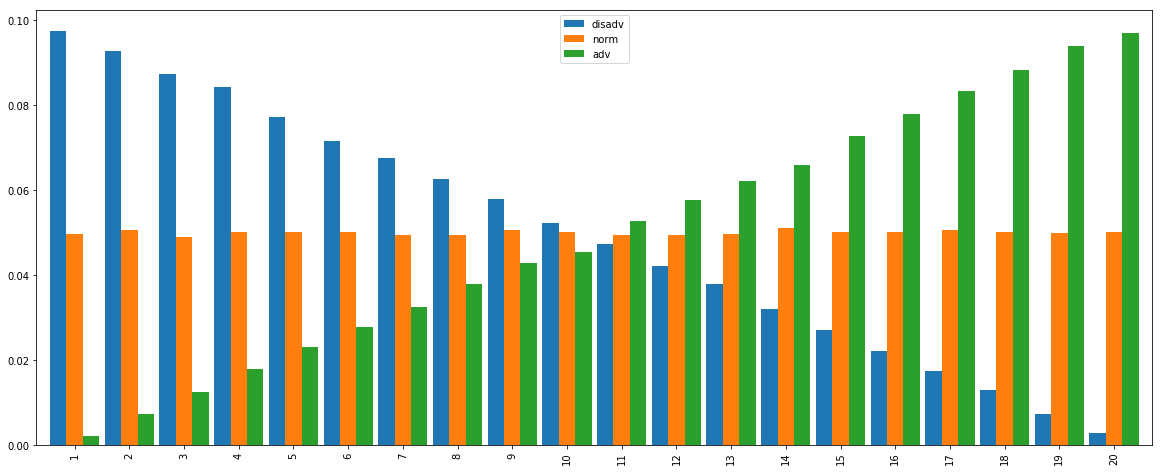

In [16]:
pd.DataFrame({"disadv": disadv, "norm": norm, "adv": adv}).plot(kind="bar", figsize=(20, 8), width=0.9)

In [17]:
(d(20).adv - d(20).disadv) * 2

<DiceExpr((adv(1d20) - disadv(1d20)) * 2)>

**todo:**
 - [x] [0.3] better attack simulation batching
 - [ ] [0.3] better expr collapse (sympy?)
 - [ ] [0.3] better DiceExpr str rendering
 - [ ] [0.3] DiceExpr.parse
 - [ ] pdist (incl composability)
 - [ ] roll logging
 - [ ] visual output (w/ scavegr)

---

In [1]:
import pandas as pd
from dicebox.dnd import attack_roll_factory, critical_roll
from dicebox import d

In [2]:
rapier_attack = attack_roll_factory("Rapier", d(8) + 4, 3)
rapier_sneak_attack = attack_roll_factory("Rapier", d(8, 6, 6, 6) + 4, 3)
rapier_assassinate_attack = attack_roll_factory("Rapier", critical_roll(d(8, 6, 6, 6) + 4), 3, critical_hits=False)

In [7]:
# note that, even with the 23 to hit, no critical hit was triggered (because critical damage is already being used)
print("\n".join(rapier_assassinate_attack(adv=True, repeat=5)))

Rapier: 18 to hit ((adv(1d20) + 3)); 28.0 damage ((2d8 + 6d6 + 4))
Rapier: 14 to hit ((adv(1d20) + 3)); 23.0 damage ((2d8 + 6d6 + 4))
Rapier: 23 to hit ((adv(1d20) + 3)); 42.0 damage ((2d8 + 6d6 + 4))
Rapier: 9 to hit ((adv(1d20) + 3)); 37.0 damage ((2d8 + 6d6 + 4))
Rapier: 17 to hit ((adv(1d20) + 3)); 34.0 damage ((2d8 + 6d6 + 4))


In [22]:
turn = [rapier_sneak_attack(), rapier_attack()]
print("\n".join(turn))

Rapier: critical miss!
Rapier: 20 to hit ((1d20 + 3)); 7 damage ((1d8 + 4))


In [6]:
def avg_attack_vs_ac(sim, AC):
    hit = ((sim["to_hit_roll"] > AC) | sim["critical_hit"]) & ~ sim["critical_miss"]
    return (hit * sim["weapon_damage_roll"]).mean()

In [7]:
%%time
# 1m simulated attacks in <180ms; avg 172 nanoseconds per attack
sneak_attack_sim = pd.DataFrame(rapier_sneak_attack(repeat=1000000, numeric=True))

CPU times: user 154 ms, sys: 19.3 ms, total: 173 ms
Wall time: 173 ms


In [8]:
# avg damage per attack vs AC 15 opponent
avg_attack_vs_ac(sneak_attack_sim, AC=15)

8.357826

In [10]:
sneak_attack_adv_sim = pd.DataFrame(rapier_sneak_attack(repeat=1000000, numeric=True, adv=True))
sneak_attack_disadv_sim = pd.DataFrame(rapier_sneak_attack(repeat=1000000, numeric=True, disadv=True))

In [22]:
# avg damage per attack (w/ advantage) vs AC 15 opponent
avg_attack_vs_ac(sneak_attack_adv_sim, AC=15)

13.634876

In [23]:
print("critical hit %:")
print(sneak_attack_disadv_sim["critical_hit"].mean(), sneak_attack_sim["critical_hit"].mean(), sneak_attack_adv_sim["critical_hit"].mean())
print("critical miss %:")
print(sneak_attack_disadv_sim["critical_miss"].mean(), sneak_attack_sim["critical_miss"].mean(), sneak_attack_adv_sim["critical_miss"].mean())

critical hit %:
0.002535 0.049956 0.09755
critical miss %:
0.097306 0.050095 0.002485


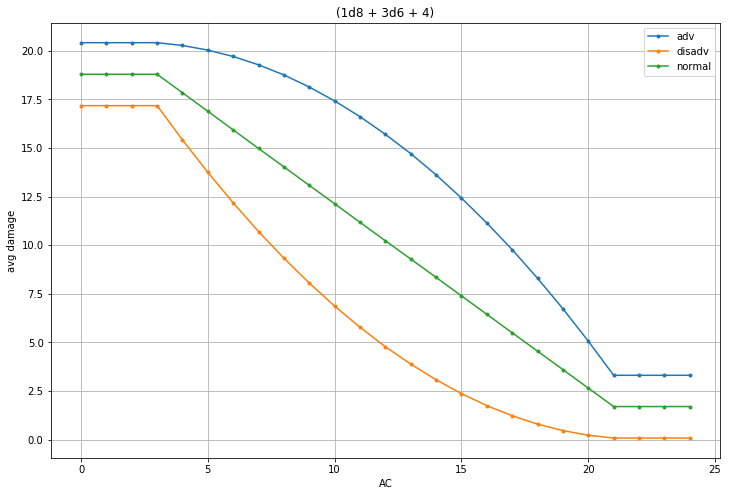

In [33]:
sneak_attack_dmg_vs_ac = pd.DataFrame([{"disadv": avg_attack_vs_ac(sneak_attack_disadv_sim, AC=AC),
                    "normal": avg_attack_vs_ac(sneak_attack_sim, AC=AC),
                    "adv": avg_attack_vs_ac(sneak_attack_adv_sim, AC=AC)}
                   for AC in range(1, 26)])
ax = sneak_attack_dmg_vs_ac.plot(marker=".", title=str(d(8, 6, 6, 6) + 4), figsize=(12, 8), grid=True)
ax.set_xlabel("AC")
ax.set_ylabel("avg damage");
# note: advantage matters most low to mid; disadvantage matters most mid to high

In [25]:
sneak_attack_dmg_vs_ac

,adv,disadv,normal
0,20.418287,17.187488,18.798094
1,20.418287,17.187488,18.798094
2,20.418287,17.187488,18.798094
3,20.418287,17.187488,18.798094
4,20.275127,15.428610,17.847122
5,20.035980,13.771453,16.895058
6,19.704112,12.207524,15.949488
7,19.275240,10.735176,15.001358
8,18.754596,9.358942,14.055646
9,18.136814,8.072483,13.110044
